## Load data

In [ ]:
%conda install conda-forge::pytorch
%pip install torch_geometric
%pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.7.0+cu128.html
%pip install torch-geometric-temporal

## Create Graph Dataset

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch_geometric_temporal import ASTGCN
from torch_geometric.utils import dense_to_sparse
from torch.amp import GradScaler, autocast
from tqdm.auto import tqdm

# your existing utils
from utils.concatenate_data import run_pipeline
from utils.build_station_weight import build_station_weights
from model.model_core_architecture import ASTGCN_V2
# 1. Load & preprocess
all_data_df, long_df = run_pipeline(
    root_xlsx_dir="Load-data",
    cleaned_csv_dir="cleaned_data",
    preprocessed_csv_dir="preprocessed_data",
    final_wide_csv="all_data_df.csv",
    final_long_csv="all_data_timeseries.csv",
)
long_df.loc[long_df['Electricity(kW)'] < 0, 'Electricity(kW)'] = 0
station_weights_df = build_station_weights(long_df)
print("Station weights:\n", station_weights_df)

# 2. Three-way split per station (70% train / 10% eval / 20% test)
def split_threeway(df, train_frac=0.7, eval_frac=0.1):
    train_list, eval_list, test_list = [], [], []
    for station, sdf in df.groupby('station_name'):
        sdf = sdf.sort_values('Date')
        n = len(sdf)
        n_train = int(n * train_frac)
        n_eval  = int(n * (train_frac + eval_frac)) - n_train
        train_list.append(sdf.iloc[:n_train])
        eval_list.append (sdf.iloc[n_train:n_train + n_eval])
        test_list.append (sdf.iloc[n_train + n_eval:])
    train_df = pd.concat(train_list).reset_index(drop=True)
    eval_df  = pd.concat(eval_list).reset_index(drop=True)
    test_df  = pd.concat(test_list).reset_index(drop=True)
    return train_df, eval_df, test_df

train_df, eval_df, test_df = split_threeway(long_df, train_frac=0.7, eval_frac=0.1)
print(f"Rows → train: {len(train_df)}, eval: {len(eval_df)}, test: {len(test_df)}")

# 3. Graph structure (fully connected)
station_names = sorted(long_df['station_name'].unique())
num_nodes     = len(station_names)
edge_index    = torch.tensor(
    [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j],
    dtype=torch.long
).t().contiguous()

# 4. Build sliding‐window tensors
def pivot_to_tensor(df, seq_len, station_names):
    pv = df.pivot(index='Date', columns='station_name', values='Electricity(kW)')
    pv = pv[station_names].fillna(0.0)
    arr = []
    for i in range(len(pv) - seq_len + 1):
        w = pv.iloc[i : i + seq_len].values  # (seq_len, N)
        arr.append(w.T)                     # (N, seq_len)
    return torch.tensor(np.stack(arr, axis=0), dtype=torch.float)

len_input = 96
pred_len  = 96

arr_tr = pivot_to_tensor(train_df, len_input + pred_len, station_names)
X_tr, Y_tr = arr_tr[:, :, :len_input], arr_tr[:, :, len_input:]
arr_ev = pivot_to_tensor(eval_df,  len_input + pred_len, station_names)
X_ev, Y_ev = arr_ev[:, :, :len_input], arr_ev[:, :, len_input:]
arr_te = pivot_to_tensor(test_df, len_input + pred_len, station_names)
X_te, Y_te = arr_te[:, :, :len_input], arr_te[:, :, len_input:]

# 5. Dataset & DataLoaders
class TemporalDataset(Dataset):
    def __init__(self, X, Y):
        self.X, self.Y = X, Y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

batch_size = 512
train_loader = DataLoader(TemporalDataset(X_tr, Y_tr), batch_size=batch_size, shuffle=True)
eval_loader  = DataLoader(TemporalDataset(X_ev, Y_ev), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TemporalDataset(X_te, Y_te), batch_size=batch_size, shuffle=False)

Station weights:
              station_name  normalized_reverse_weight
0         Data_สถานีชาร์จ                   1.000000
1     Data_อาคารจามจุรี 9                   1.000000
2   Data_อาคารจุลจักรพงษ์                   1.002786
3  Data_อาคารบรมราชกุมารี                   1.002786
4      Data_อาคารจามจุรี4                   1.094225
5   Data_อาคารวิทยนิเวศน์                   2.384106
Rows → train: 128887, eval: 18412, test: 36829


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = {
    "nb_block": 2,
    "in_channels": 1,
    "K": 2,
    "nb_chev_filter": 64,
    "nb_time_filter": 64,
    "time_strides": 1,
    "num_for_predict": pred_len,
    "len_input": len_input,
    "num_of_vertices": num_nodes,
    "normalization": "sym",
    "bias": True,
}
model     = ASTGCN_V2(num_nodes=num_nodes, **config).to(device)
criterion = nn.MSELoss()
max_lr = 3e-2
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=1e-4)


num_epochs = 50
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.3,
)
scaler = GradScaler()

# Early stopping parameters
patience       = 5   # you might also increase patience for more epochs
best_eval_loss = float('inf')
no_improve     = 0

for epoch in range(1, num_epochs + 1):
    model.train()
    total_train = 0.0
    for Xb, Yb in tqdm(train_loader, desc=f"Epoch {epoch} train"):
        Xb = Xb.unsqueeze(2).to(device)  # [B, N, 1, len_input]
        Yb = Yb.to(device)
        optimizer.zero_grad()
        with autocast("cuda"):
            preds = model(Xb, edge_index.to(device))
            loss  = criterion(preds, Yb)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_train += loss.item() * Xb.size(0)
    avg_train = total_train / len(train_loader.dataset)

    model.eval()
    total_eval = 0.0
    with torch.no_grad():
        for Xb, Yb in eval_loader:
            Xb = Xb.unsqueeze(2).to(device)
            Yb = Yb.to(device)
            preds = model(Xb, edge_index.to(device))
            total_eval += criterion(preds, Yb).item() * Xb.size(0)
    avg_eval = total_eval / len(eval_loader.dataset)

    print(f"Epoch {epoch:02d} — Train Loss: {avg_train:.4f} | Eval Loss: {avg_eval:.4f}")

    # Early stopping check
    if avg_eval < best_eval_loss:
        best_eval_loss = avg_eval
        no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")
        print(f"  → New best model saved (Eval Loss: {best_eval_loss:.4f})")
    else:
        no_improve += 1
        print(f"  → No improvement for {no_improve}/{patience} epochs")
        if no_improve >= patience:
            print(f"Stopping early at epoch {epoch} (no improvement in last {patience} epochs)")
            break

# Load best model before final test
# model.load_state_dict(torch.load("best_model.pt"))

# 8. Final test-set evaluation
model.eval()
total_test = 0.0
with torch.no_grad():
    for Xb, Yb in test_loader:
        Xb = Xb.unsqueeze(2).to(device)
        Yb = Yb.to(device)
        preds = model(Xb, edge_index.to(device))
        total_test += criterion(preds, Yb).item() * Xb.size(0)
avg_test = total_test / len(test_loader.dataset)
print(f"Test Loss: {avg_test:.4f}")


Epoch 1 train:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1 train:   0%|          | 0/49 [00:00<?, ?it/s]


AttributeError: 'ASTGCN' object has no attribute '_TemporalBlock__st_blocks'

In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = ASTGCN_V2(num_nodes=num_nodes, **config).to(device)
# 1. Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# 2. Combine train+test, pivot to wide form
df_all = pd.concat([train_df, test_df], ignore_index=True)
pivot = (
    df_all
    .pivot(index='Date', columns='station_name', values='Electricity(kW)')
    .reindex(columns=station_names)  # ensure column order matches model
    .fillna(0.0)
)
dates = pivot.index
T = len(dates)

# 3. Build every sliding window of length `len_input`
#    and assemble into a tensor of shape (W, N, 1, len_input)
len_input = 96
pred_len   = 96  # your model’s num_for_predict
max_start  = T - len_input - pred_len + 1
windows    = []
for t0 in range(max_start):
    arr = pivot.iloc[t0 : t0 + len_input].values  # (len_input, N)
    windows.append(arr.T)                          # → (N, len_input)

X_all = np.stack(windows, axis=0)                   # (W, N, len_input)
X_all = torch.from_numpy(X_all).float().unsqueeze(2)  # (W, N, 1, len_input)

# 4. Batch through the model
batch_size = 512
loader = DataLoader(TensorDataset(X_all), batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_preds = []
with torch.no_grad():
    for (Xb,) in tqdm(loader, desc="Predicting"):
        Xb = Xb.to(device)
        yb = model(Xb, edge_index.to(device))  # → (B, N, pred_len)
        all_preds.append(yb.cpu().numpy())
all_preds = np.concatenate(all_preds, axis=0)      # (W, N, pred_len)

# 5. Extract the first‐step forecasts
first_step = all_preds[:, :, 0]                   # (W, N)

# 6. Build long‐form DataFrame of predictions
pred_dates = dates[len_input : len_input + first_step.shape[0]]
records = []
for w, dt in enumerate(pred_dates):
    for i, station in enumerate(station_names):
        records.append((dt, station, first_step[w, i]))
df_preds = pd.DataFrame(records, columns=['Date','station_name','Predicted(kW)'])

# 7. Merge with your test_df and compute MAE
df_merged = (
    test_df
    .merge(df_preds, on=['Date','station_name'], how='left')
    .sort_values(['Date','station_name'])
    .reset_index(drop=True)
)
df_eval = df_merged.dropna(subset=['Predicted(kW)']).copy()

mae = mean_absolute_error(
    df_eval['Electricity(kW)'].values,
    df_eval['Predicted(kW)'].values
)
print(f"Test MAE (first‐step): {mae:.4f}  "
      f"[dropped {len(df_merged) - len(df_eval)} missing rows]")


Predicting:  11%|█         | 7/63 [00:06<00:51,  1.09it/s]


KeyboardInterrupt: 

## Evaluation

In [79]:
from utils.error_analyzer import  compute_station_metrics
metrics_df = compute_station_metrics(df_eval, station_weights_df)
metrics_df

c:\Users\patar\Documents\superai-intern\superaiss5-intern-vpp\utils\error_analyzer.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_metrics)


,station_name,MAE,MSE,RMSE,WAPE
0,Data_สถานีชาร์จ,22.599283,1824.063835,42.70906,0.392013
1,Data_อาคารจามจุรี 9,33.804529,2020.819023,44.953521,0.134854
2,Data_อาคารจามจุรี4,6.241302,68.630183,8.284334,0.193109
3,Data_อาคารจุลจักรพงษ์,8.759184,125.22006,11.190177,0.130299
4,Data_อาคารบรมราชกุมารี,17.170017,533.717505,23.102327,0.16505
5,Data_อาคารวิทยนิเวศน์,2.575842,19.547334,4.421237,1.02525
6,all_station,16.700534,857.610529,29.284988,0.177252


In [82]:
metrics_df.to_csv("error_analysis_metrics_with_bestmodel.csv", index=False)

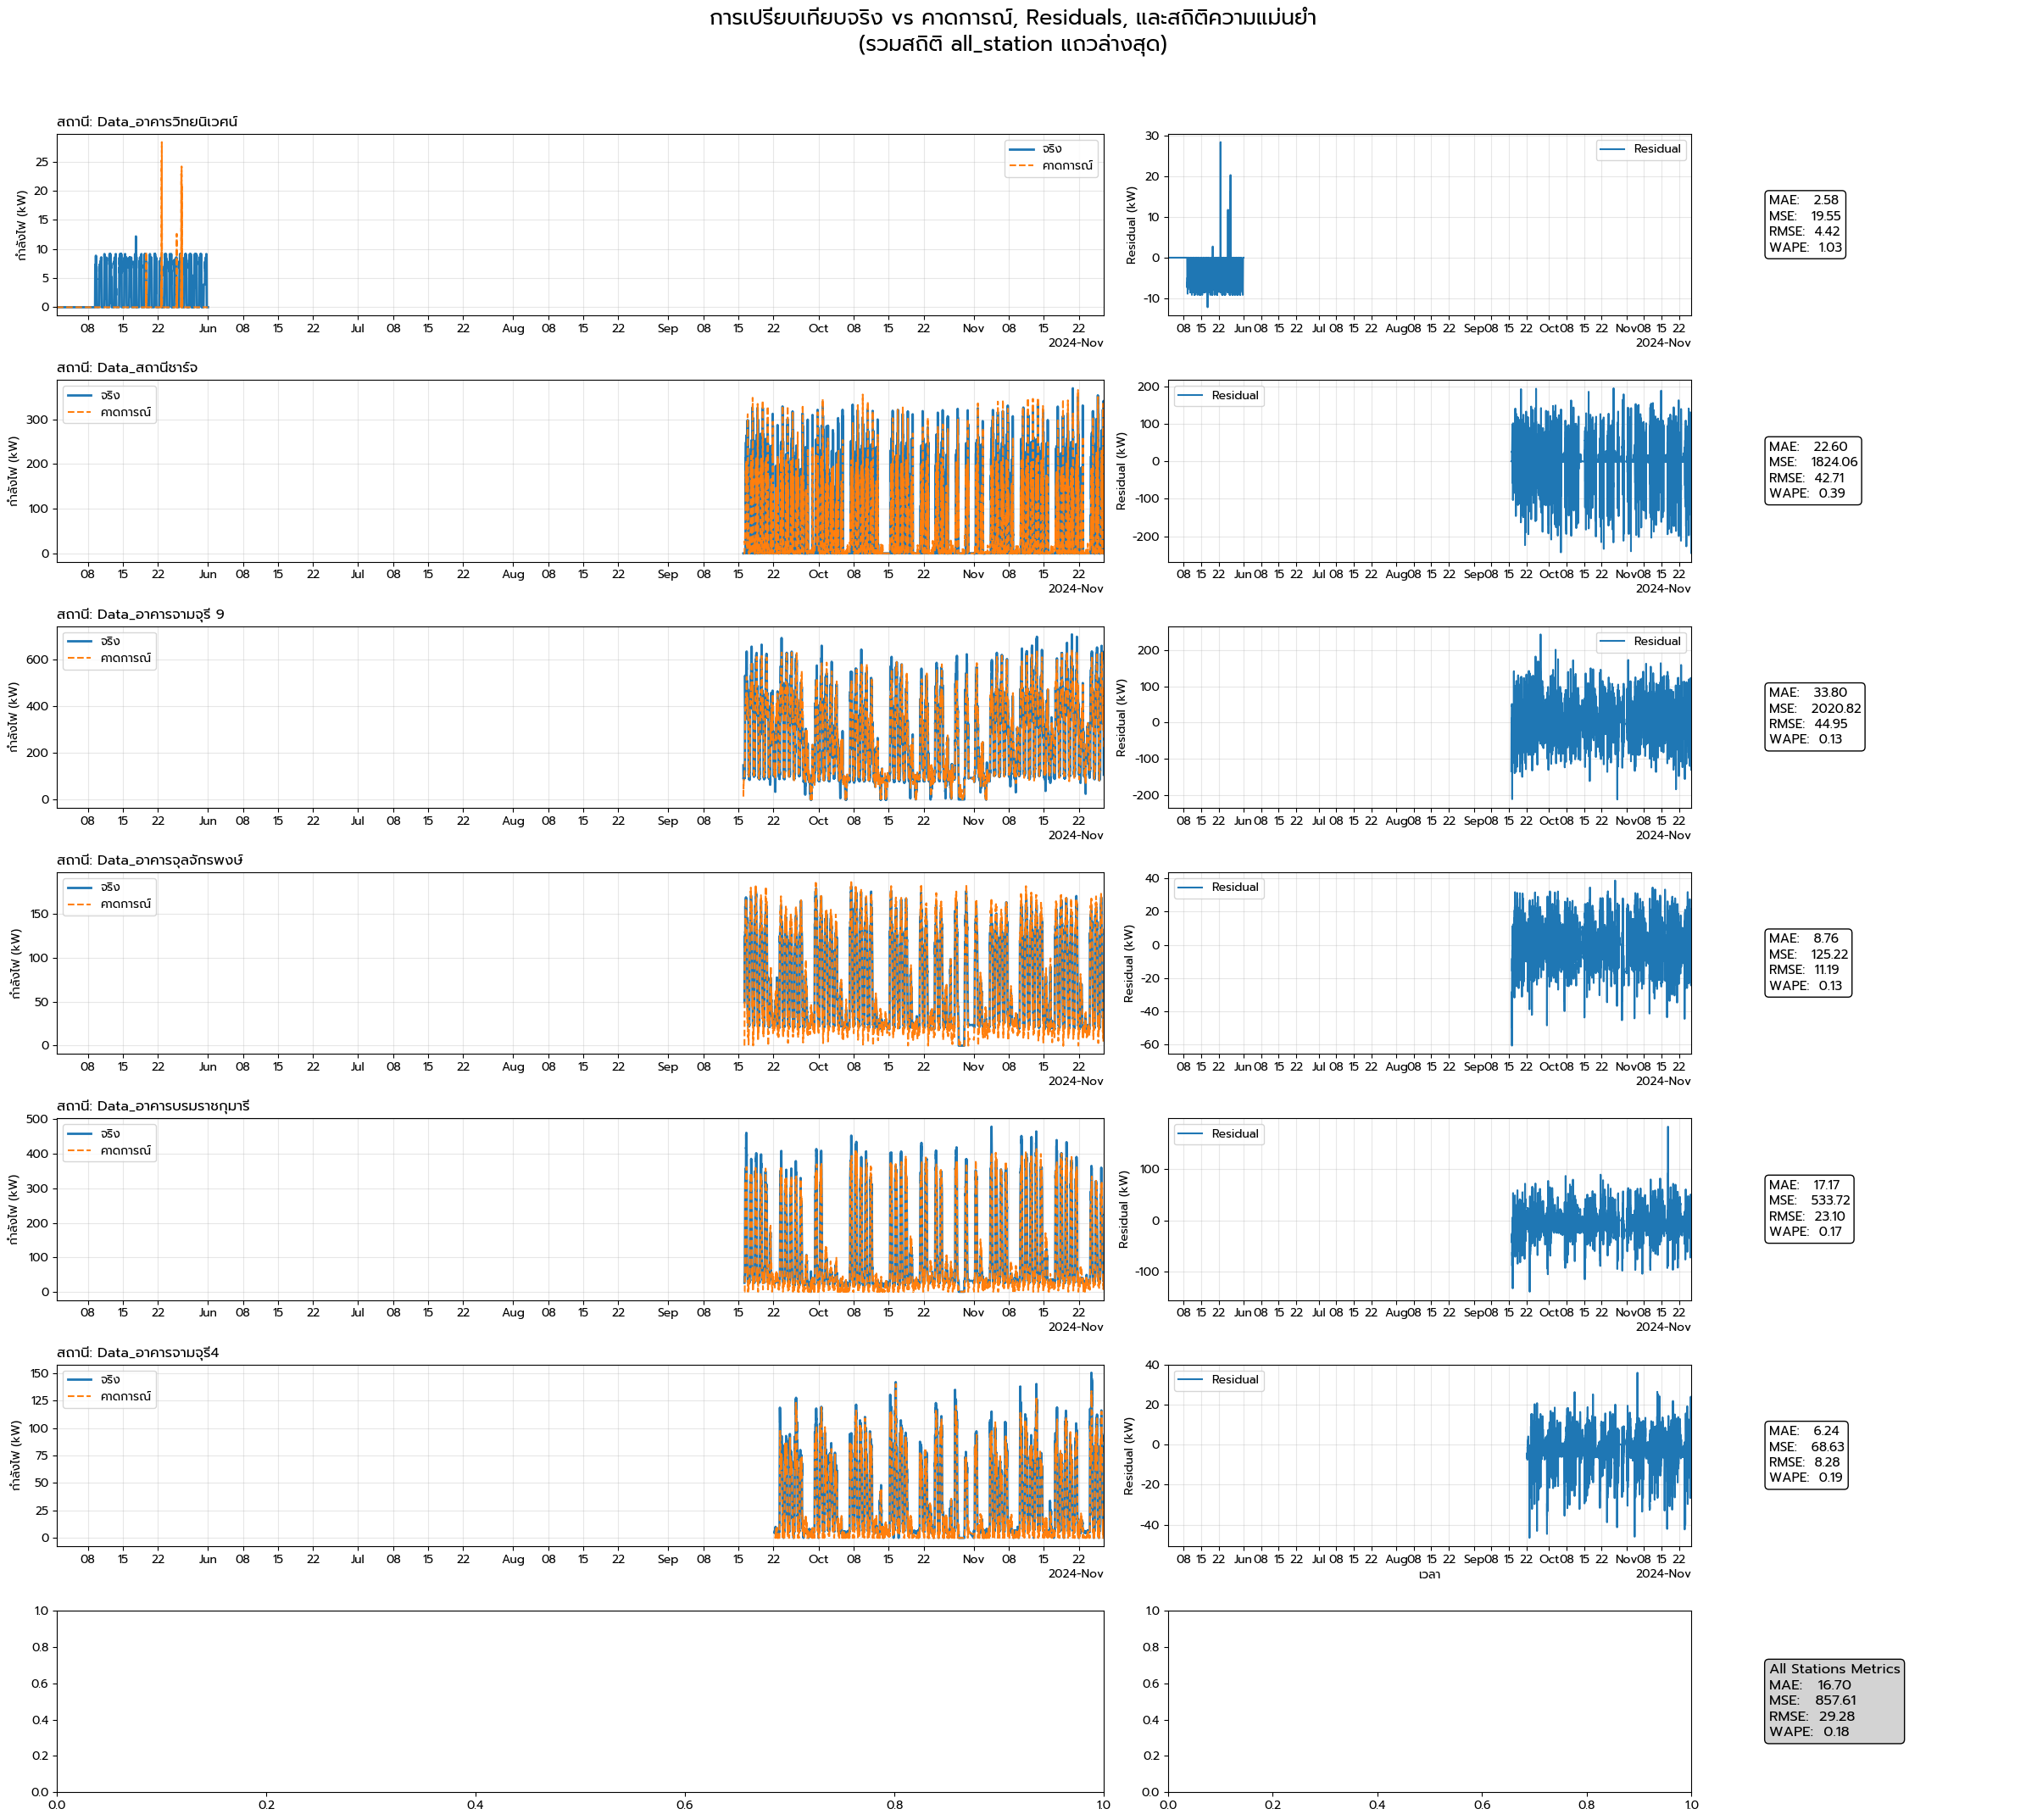

In [80]:
from utils.error_analyzer import plot_all_stations_with_overall
# Usage:
plot_all_stations_with_overall(df_eval, metrics_df)


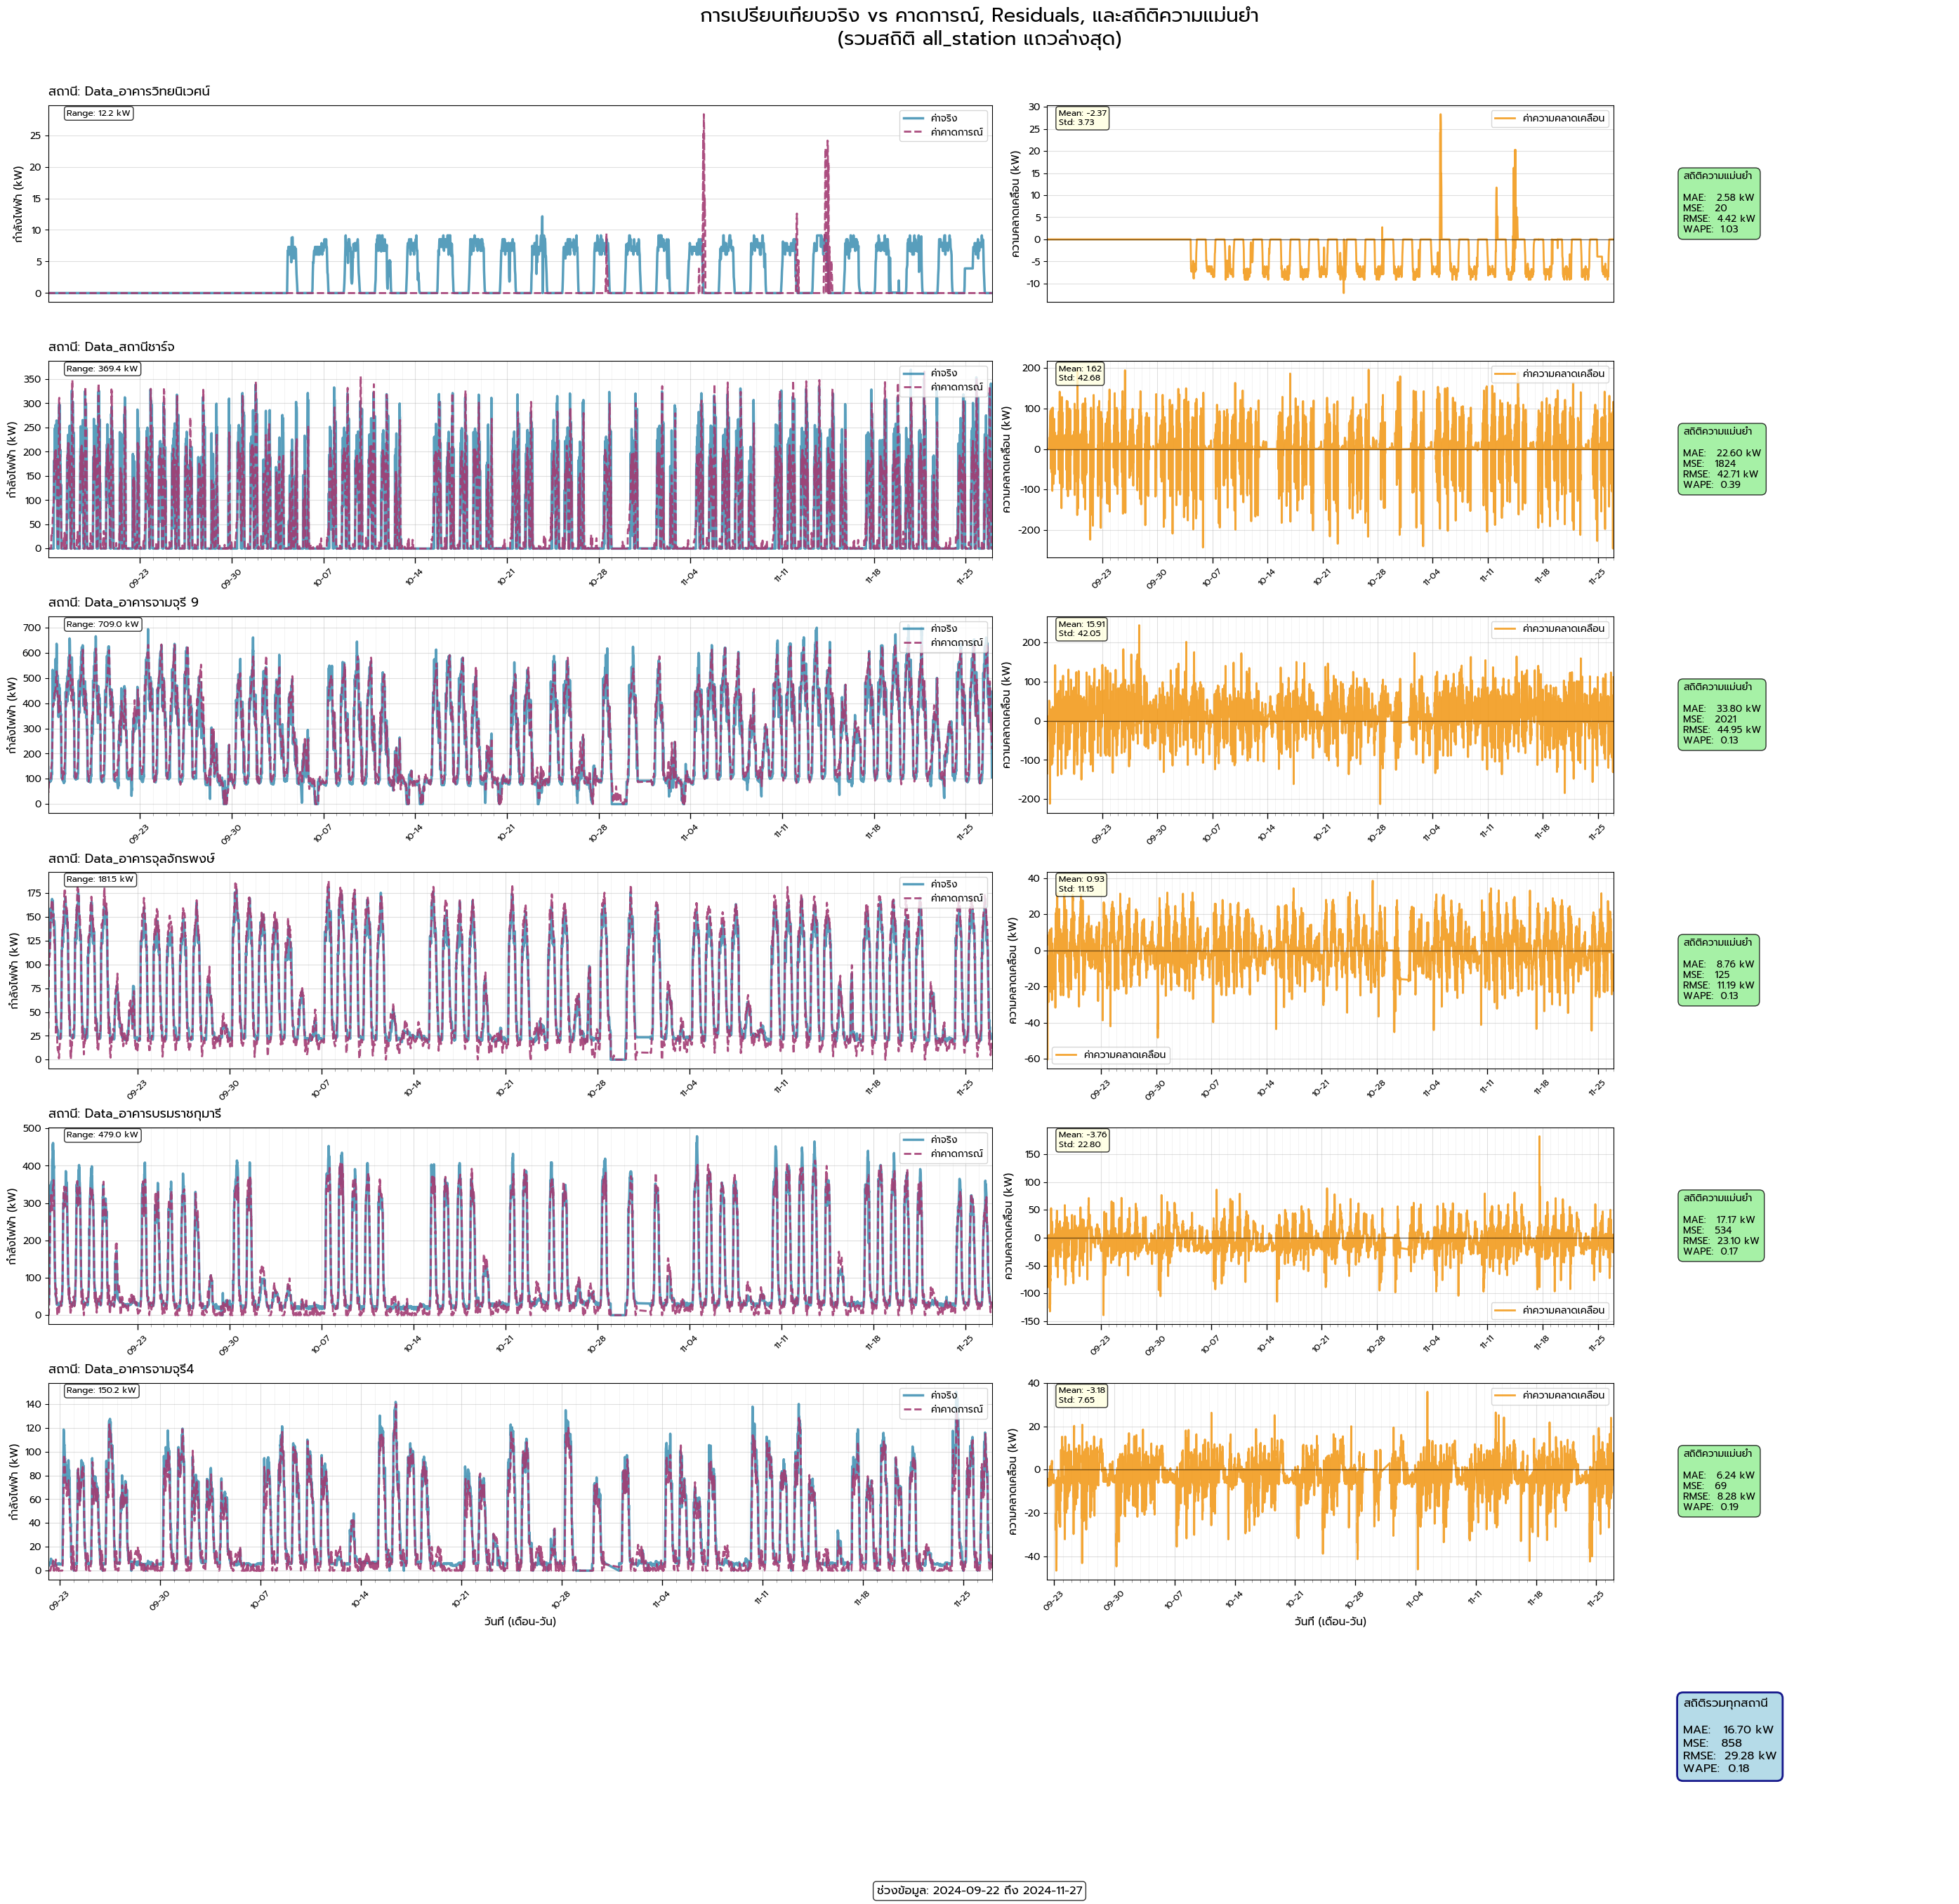

In [81]:
from utils.error_analyzer import plot_all_stations_with_daily_ticks
# Usage:
plot_all_stations_with_daily_ticks(df_eval, metrics_df, show_daily_grid=True, daily_tick_interval=1)


c:\Users\patar\Documents\superai-intern\superaiss5-intern-vpp\utils\error_analyzer.py:364: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby(['station_name','weekday']).agg(


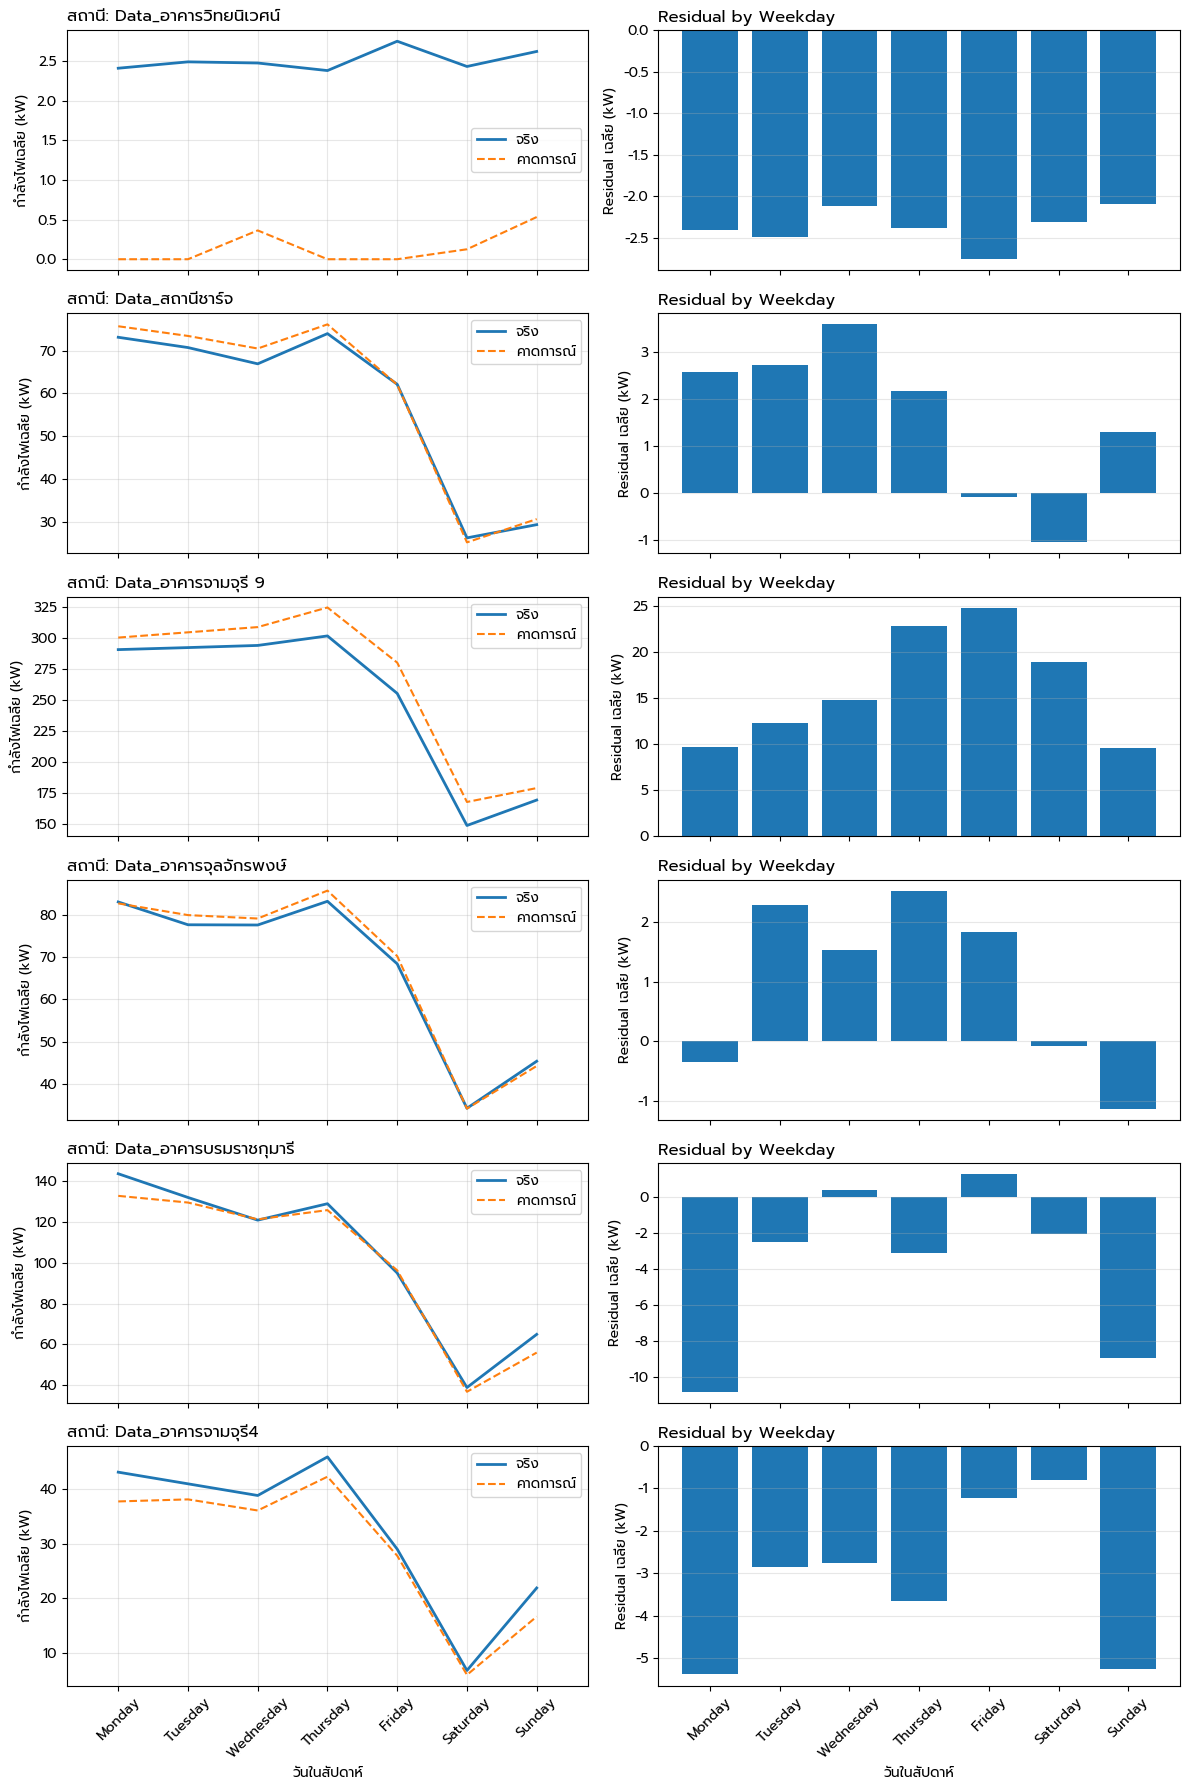

In [94]:
from utils.error_analyzer import plot_weekday_analysis

plot_weekday_analysis(df_eval, metrics_df)

Saved graph_map.html with Folium visualization.


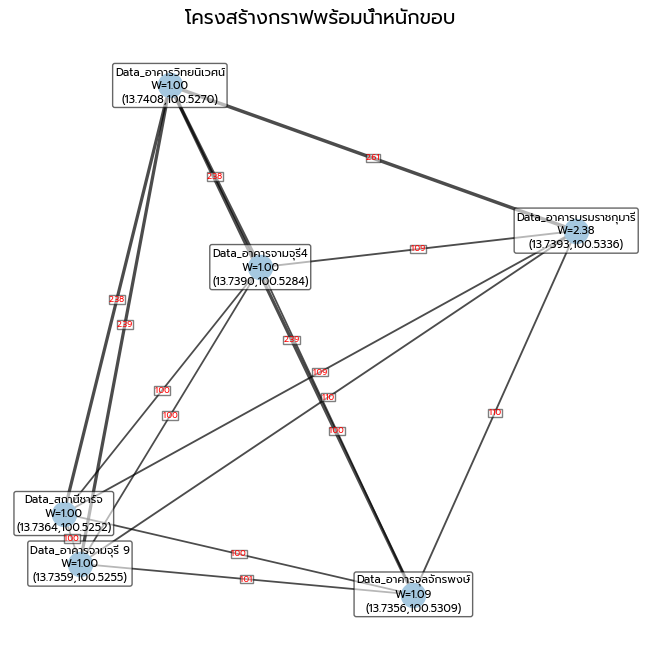

In [7]:
# main.py
import networkx as nx
import torch
import matplotlib.pyplot as plt
from matplotlib import font_manager
from utils.visualizer import create_graph_map, plot_static_graph

# Assuming your data variables are already defined:
# locations, edge_index, edge_weight, station_weights_df, train_df

# Build station list and ratios
station_names = list(locations.keys())
ei = edge_index.cpu().numpy()
ew = edge_weight.cpu().numpy()
station_weights = ew.tolist()

# Build NetworkX graph
G = nx.Graph()
for i, name in enumerate(station_names):
    G.add_node(i)
for (u, v), w in zip(ei.T, ew):
    G.add_edge(u, v, weight=float(w))

# Thai font for Matplotlib
font_path = r"c:\Users\patar\Documents\superai-intern\superaiss5-intern-vpp\Prompt_Font\Prompt-Regular.ttf"
thai_font = font_manager.FontProperties(fname=font_path)

# Recreate pos dict
pos = {i: locations[name][::-1] for i, name in enumerate(station_names)}

# 1) Save Folium map
m = create_graph_map(locations, ew.tolist(), G, enable_satellite=True)
m.save("graph_map.html")
print("Saved graph_map.html with Folium visualization.")

# 2) Show static Matplotlib graph
plot_static_graph(G, pos, station_names, ew.tolist(), locations, thai_font)

## Inference Model

In [3]:
import numpy as np
import torch
import onnxruntime as ort

class InferenceModel:
    def __init__(self, onnx_path="astgcn_v2.onnx", device="cpu"):
        providers = (["CUDAExecutionProvider","CPUExecutionProvider"]
                     if device.startswith("cuda") else ["CPUExecutionProvider"])
        self.sess = ort.InferenceSession(onnx_path, providers=providers)

        # Inspect the ONNX inputs
        inputs = self.sess.get_inputs()
        names = [inp.name for inp in inputs]
        if len(names) == 2:
            # graph expects [X, edge_index]
            self.input_name, self.edge_name = names
            self.need_edge = True
        elif len(names) == 1:
            # graph only expects [X], edge_index is built-in
            self.input_name = names[0]
            self.edge_name = None
            self.need_edge = False
        else:
            raise RuntimeError(f"Unexpected number of inputs in ONNX model: {len(names)}")

        self.output_name = self.sess.get_outputs()[0].name

    def forecast(self, X: torch.Tensor, edge_index: torch.Tensor = None) -> torch.Tensor:
        """
        X: [B, N, 1, seq_len]
        edge_index: [2, E] (only required if the ONNX session expects it)
        """
        Xn = X.cpu().numpy().astype(np.float32)
        feed = {self.input_name: Xn}

        if self.need_edge:
            if edge_index is None:
                raise ValueError("This model requires edge_index, but none was given.")
            En = edge_index.cpu().numpy().astype(np.int64)
            feed[self.edge_name] = En

        out = self.sess.run([self.output_name], feed)[0]
        return torch.from_numpy(out)

# --- Example usage ---

# Case 1: ONNX with two inputs
inf = InferenceModel("./model/astgcnv2_50epoch.onnx", device="cpu")


NameError: name 'edge_index' is not defined

In [6]:
# 1. Prepare device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
locations = {
    "Data_สถานีชาร์จ": (13.736418765099916, 100.52524210026607), # Corrected coordinates is 13.736418765099916, 100.52524210026607
    "Data_อาคารจามจุรี4": (13.738963239687536, 100.52843073814955), # Corrected coordinates is 13.738963239687536, 100.52843073814955
    "Data_อาคารจามจุรี 9": (13.735899096644642, 100.52550388047727), # Corrected coordinates is 13.735899096644642, 100.52550388047727
    "Data_อาคารจุลจักรพงษ์": (13.73558133067766, 100.5309154651327), # Corrected coordinates is 13.73558133067766, 100.5309154651327
    "Data_อาคารบรมราชกุมารี": (13.739340161417255, 100.53355852280504), # Corrected coordinates is 13.739340161417255, 100.53355852280504
    "Data_อาคารวิทยนิเวศน์": (13.740842756926996, 100.5269634228051), # Corrected coordinates is 13.740842756926996, 100.5269634228051
}

station_names = list(locations.keys())
num_nodes = len(station_names)

# fully connected edges (i != j)
@torch.no_grad()
def get_fully_connected_edge_index(num_nodes):
    return torch.tensor(
        [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j],
        dtype=torch.long
    ).t().contiguous()

edge_index = get_fully_connected_edge_index(num_nodes).to(device)
num_nodes = 6
len_input = 96
X_test = torch.randn(8, num_nodes, 1, len_input)
preds = inf.forecast(X_test, edge_index)                # must pass edge_index
preds

Using device: cuda


tensor([[[ 0.0000,  0.0000,  0.0000,  ..., 39.6420, 39.1797, 36.8630],
         [27.8857, 38.5548, 42.6128,  ..., 64.7265, 69.0201, 66.5139],
         [ 0.0000,  1.7015,  4.0038,  ..., 78.6018, 77.7072, 76.3418],
         [ 5.9739,  6.4539,  5.9342,  ...,  0.0000,  0.2721,  1.9109],
         [ 0.0000,  0.0000,  0.0000,  ..., 24.2644, 23.8957, 23.0827],
         [ 3.8433,  3.7572,  3.2728,  ...,  3.8302,  4.0374,  3.8216]],

        [[ 0.0000,  0.0000,  0.0000,  ..., 36.6545, 34.0877, 30.8033],
         [25.2878, 35.1730, 38.9574,  ..., 65.6729, 69.9046, 67.9522],
         [ 0.0000,  5.7398,  6.3080,  ..., 83.2347, 83.2010, 81.6917],
         [ 4.4637,  5.1753,  4.6248,  ...,  0.7033,  1.1734,  2.4833],
         [ 5.6593,  4.0445,  3.4375,  ..., 14.7290, 16.9798, 16.8848],
         [ 0.0000,  0.6675,  0.1571,  ...,  3.5725,  3.5024,  3.0273]],

        [[ 0.0000,  0.0000,  0.0000,  ..., 35.5706, 34.5959, 32.0399],
         [31.2725, 41.3873, 47.7676,  ..., 65.2238, 69.6952, 68.0252],
  